In [150]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Hidden Markov Model Assignment

The robot can move on the cells with light background, but cannot go over the obstacles, which have the dark blue background.

In [151]:
# Boolean representation of a random maze. True=feasible, False=obstacle.
# Use the maze corresponding to your group!
maze = np.ones((4, 16), dtype=bool)
rows, cols = 4, 16
N = rows*cols
obstacles = [11,12,13,14,19,21,23,25,27,30,35,39,48,49,50,51,52,53,55,59,62]
for cell in obstacles:
    r = cell // cols
    c = cell % cols
    maze[r][c] = False

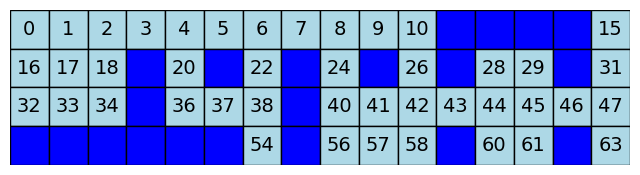

In [152]:
def plot_maze(ax, maze, skip_walls=True):
    cell_idx = 0
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            color = 'lightblue' if maze[r, c] == 1 else 'blue'
            ax.add_patch(patches.Rectangle((c, rows - 1 - r), 1, 1, edgecolor='black', facecolor=color))
            if maze[r, c] == 1 or not skip_walls:
                ax.text(c + 0.5, rows - 1 - r + 0.5, str(cell_idx), color='black', ha='center', va='center', fontsize=14)
            cell_idx += 1

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)


    ax.set_aspect('equal')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 6))

plot_maze(ax, maze)

In [153]:
rows, cols = maze.shape
states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c]]

states_with_idx = []
for r in range(rows):
    for c in range(cols):
        state = (r, c)
        states_with_idx.append(state) if maze[r, c] else states_with_idx.append(None)
        
states_with_idx

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 None,
 None,
 None,
 None,
 (0, 15),
 (1, 0),
 (1, 1),
 (1, 2),
 None,
 (1, 4),
 None,
 (1, 6),
 None,
 (1, 8),
 None,
 (1, 10),
 None,
 (1, 12),
 (1, 13),
 None,
 (1, 15),
 (2, 0),
 (2, 1),
 (2, 2),
 None,
 (2, 4),
 (2, 5),
 (2, 6),
 None,
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 None,
 None,
 None,
 None,
 None,
 None,
 (3, 6),
 None,
 (3, 8),
 (3, 9),
 (3, 10),
 None,
 (3, 12),
 (3, 13),
 None,
 (3, 15)]

In [154]:
# Suggested names for the possible observations. If can be seen as a binary digit from 0 to 15, where the least significant bit indicates West.
# This may be usefule to code the emission matrix
letters = ['N', 'S', 'E', 'W']
vocabulary = []
for i in range(2**len(letters)):  # observations can be indexed with numbers 0 to 15
    binary = format(i, '04b')  # 4-bit format interpreted as possibility to move N,S,E,W
    combination = ''.join([letters[j] for j in range(4) if binary[j] == '1'])
    vocabulary.append(combination)

In [155]:
vocabulary

['',
 'W',
 'E',
 'EW',
 'S',
 'SW',
 'SE',
 'SEW',
 'N',
 'NW',
 'NE',
 'NEW',
 'NS',
 'NSW',
 'NSE',
 'NSEW']

In [156]:
pi = np.zeros(cols*rows, dtype=float)
for i in range(len(pi)):
    pi[i] = 1/len(states) if states_with_idx[i] is not None else 0
pi

array([0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.        , 0.        , 0.        , 0.        ,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.        , 0.02325581, 0.        , 0.02325581,
       0.        , 0.02325581, 0.        , 0.02325581, 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.02325581, 0.        , 0.02325581])

## 1 HMM Definition and Trajectory Generation

### 1.1 Transition probability definition

Define the *transition probability matrix* $A$ corresponding to the robot maze. Consider that:

* The robot can only reach a neighboring cell.
* The robot can move North, South, East, West.
* Diagonal moves are not allowed.
* Passing over obstacles is not allowed.
* Feasible transitions are equally probable.

In [157]:
def count_neighbours(states, state):
    count = 0
    neighbours = []
    if (state[0], state[1]-1) in states:
        count += 1
        neighbours.append((state[0], state[1]-1))
    if (state[0], state[1]+1) in states:
        count += 1
        neighbours.append((state[0], state[1]+1))
    if (state[0]-1, state[1]) in states:
        count += 1
        neighbours.append((state[0]-1, state[1]))
    if (state[0]+1, state[1]) in states:
        count += 1
        neighbours.append((state[0]+1, state[1]))
    return count, neighbours

In [158]:
A = np.zeros((rows*cols, rows*cols))
for state in states:
    count_neighbours_res = count_neighbours(states, (state[0],state[1]))
    for neighbour in count_neighbours_res[1]:
        A[states_with_idx.index((state[0],state[1])), neighbour[1] + neighbour[0]*cols] = 1 / count_neighbours_res[0]

for row in A:
    for val in row:
        print(f"{val:.2f}", end=" ")
    print()

0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.33 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.33 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.50 0.00 0.50 0.00 0.00 0.

### 1.2 Emission probability definition

Define the *emission probability matrix* $B$.
* After each move, the robot senses whether the cells to the North, South, East, West are feasible.
* There are 16 possible observations (previously defined variable `vocabulary`).

In [159]:
def vocabulary_counter(vocabulary, states):
    dict = {}
    for voc in vocabulary:
        dict[voc] = []
    for state in states:
        obs = ''
        if state is not None:
            if (state[0]-1, state[1]) in states:
                obs += 'N'
            if (state[0]+1, state[1]) in states:
                obs += 'S'
            if (state[0], state[1]+1) in states:
                obs += 'E'
            if (state[0], state[1]-1) in states:
                obs += 'W'
            
        dict[obs].append(state)
    
    return dict

In [160]:
B = np.zeros((rows*cols, len(vocabulary)))
dict = vocabulary_counter(vocabulary, states)
for voc in dict:
    for state in dict[voc]:
        B[state[0]*cols + state[1], vocabulary.index(voc)] = 1
        
## if any row sums to zero we have to put 1 in the first column
for row in B:
    if np.sum(row) == 0:
        row[0] = 1

for row in B:
    for val in row:
        print(f"{val:.2f}", end=" ")
    print()

0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 0.00 0.00 0.00 0.0

### 1.3 Trajectory Sampling

Sample and visualize a state and observation sequences $Z$ and $Y$ of
length $T = 20$ compatible with the previous hypotheses.

* Use the previously defined transition and emission matrices
* Consider the initial position equiprobable among the admissible states

In [161]:
def generate_sequence(T, A, B, pi, vocabulary):
    Z = np.empty(shape=T, dtype=int)
    Y = np.empty(shape=T, dtype=object)

    # initial state 
    Z[0] = np.random.choice(N, p=pi)
    Y[0] = vocabulary[np.random.choice(len(vocabulary), p=B[Z[0]])]

    for t in range(1, T):
        # transition
        Z[t] = np.random.choice(N, p=A[Z[t-1]])
        # emission according to noisy probabilities
        Y[t] = vocabulary[np.random.choice(len(vocabulary), p=B[Z[t]])]
    return Z, Y

T = 20
Z, Y = generate_sequence(T, A, B, pi, vocabulary)
print(Z)
print(Y)

[ 8  7  8  7  6 22 38 37 36 37 38 54 38 37 38 22  6  5  6  5]
['SEW' 'EW' 'SEW' 'EW' 'SEW' 'NS' 'NSW' 'EW' 'NE' 'EW' 'NSW' 'N' 'NSW'
 'EW' 'NSW' 'NS' 'SEW' 'EW' 'SEW' 'EW']


## 2 Decoding and inference

### 2.1 Likelihood

Compute the likelihood of the obtained observation sequence $Y$.

In [162]:
def likelihood(A, B, pi, Y):
    alpha_all = np.zeros((T, N))

    for t in range(T):
        for z_t in range(N):
            if t == 0:
                alpha_all[t, z_t] = pi[z_t] * B[z_t, vocabulary.index(Y[t])]
            else:
                for z_prev in range(N):
                    alpha_all[t, z_t] += alpha_all[t-1, z_prev] * A[z_prev, z_t] * B[z_t,vocabulary.index(Y[t])]

    #print(alpha_all)           
    P_Y = np.sum(alpha_all[T-1, :])
    return P_Y

In [163]:
print(f"The probability of our sequence is: {float(likelihood(A, B, pi, Y))}")

The probability of our sequence is: 2.76918223611687e-07


### 2.1 Decoding 

Obtain the most probable state sequence, given the observation sequence $Y$.

In [ ]:
def viterbi(A, B, pi, Y):
    v_all = np.zeros((T, N))
    bp_all = np.zeros((T, N), dtype=int)

    for i in range(N):
        v_all[0, i] = pi[i] * B[i, vocabulary.index(Y[0])]

    for t in range(1, T):
        for j in range(N):
            max_val = -1
            max_idx = -1
            for i in range(N):
                val = v_all[t-1, i] * A[i, j]
                if val > max_val:
                    max_val = val
                    max_idx = i
            v_all[t, j] = max_val * B[j, vocabulary.index(Y[t])]
            bp_all[t, j] = max_idx
            
    Z_vit = np.zeros(T, dtype=int)
    Z_vit[T - 1] = np.argmax(v_all[T - 1]) 
    for t in range(T - 2, -1, -1):
        Z_vit[t] = bp_all[t + 1, Z_vit[t + 1]] 

    return Z_vit

In [165]:
Z_vit = viterbi(A, B, pi, Y)
print([states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit])
print([int(z) for z in Z])
Z_vit_list = [states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit]

diffs = [a - b for a, b in zip(Z, Z_vit_list)]
res = [f'error at pos {i}' if int(z) != 0 else 'correct' for i,z in enumerate(diffs)]
print(res)

mismatches = sum(r != "correct" for r in res )
print(f"mismatch: {mismatches/len(res)}")

[2, 3, 4, 5, 6, 22, 38, 37, 36, 37, 38, 54, 38, 37, 38, 22, 6, 5, 4, 3]
[8, 7, 8, 7, 6, 22, 38, 37, 36, 37, 38, 54, 38, 37, 38, 22, 6, 5, 6, 5]
['error at pos 0', 'error at pos 1', 'error at pos 2', 'error at pos 3', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'error at pos 18', 'error at pos 19']
mismatch: 0.3


### 2.2 Filtering

Obtain the filtering distribution $P(z_t \mid y_{1:t})$ at each time step $t$.

In [166]:
def filtering(A, B, pi, Y):
    alpha_pred = pi
    alpha_all = np.zeros((T, N))
    for t in range(T):
        alpha_upd = alpha_pred * B[:, vocabulary.index(Y[t])]  
        alpha_upd = alpha_upd / np.sum(alpha_upd)

        alpha_all[t, :] = alpha_upd

        alpha_pred = A.T @ alpha_upd
    return alpha_all

In [167]:
alpha_all = filtering(A, B, pi, Y)
for t in range(T):
    print(f"t = {t}, alpha = {alpha_all[t]}")

t = 0, alpha = [0.         0.16666667 0.16666667 0.         0.16666667 0.
 0.16666667 0.         0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.16666667
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
t = 1, alpha = [0.         0.         0.         0.28571429 0.         0.28571429
 0.         0.28571429 0.         0.14285714 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

In [168]:
def plot_heatmap(alpha_t, t):
    grid = alpha_t.reshape((4, 16))

    plt.figure(figsize=(5, 5))
    im = plt.imshow(grid, origin='upper', cmap='viridis',vmax=1)
    plt.colorbar(im, label='P(z_t = cell | Y1:t)')
    plt.title(f'Filtering heatmap at time t = {t}')
    plt.xlabel('column')
    plt.ylabel('row')
    plt.tight_layout()
    plt.show()

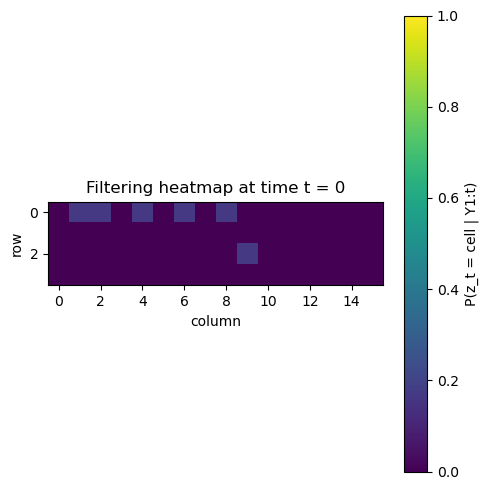

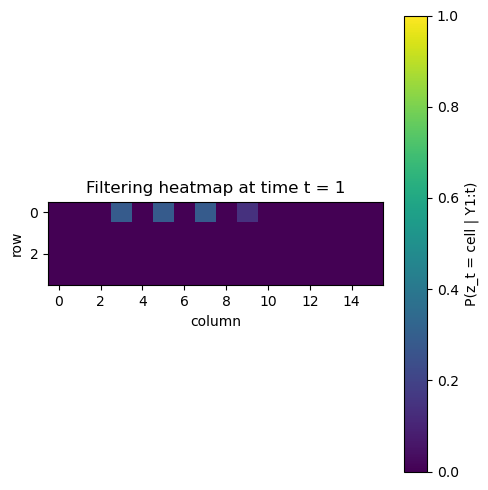

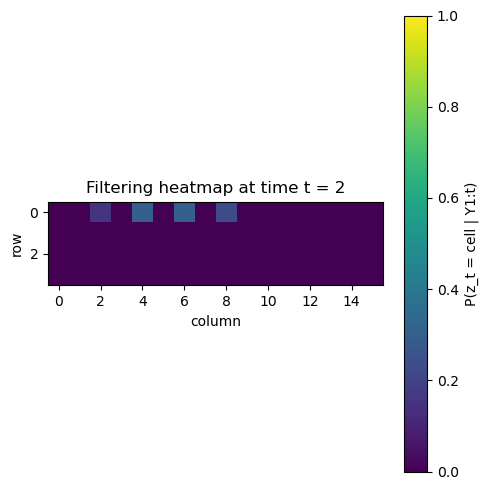

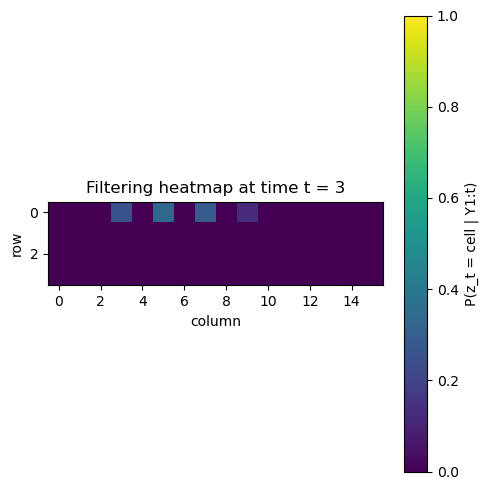

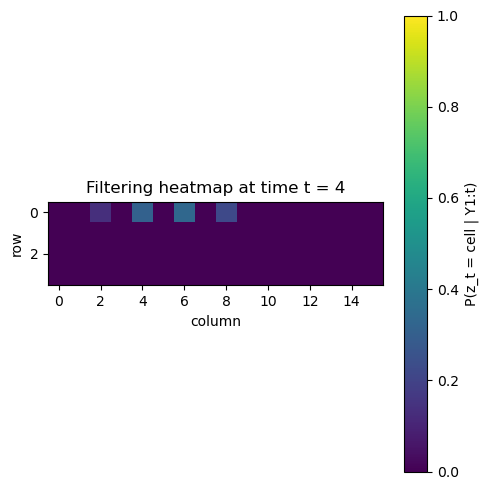

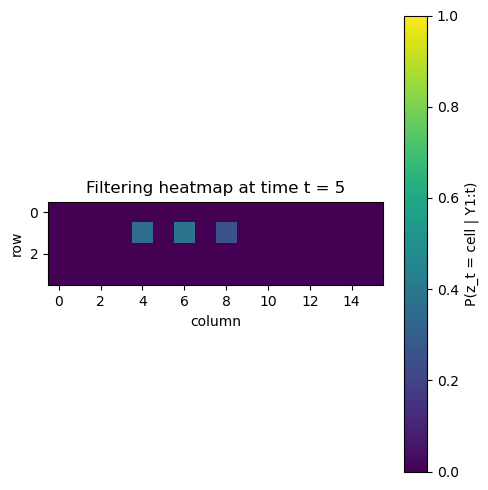

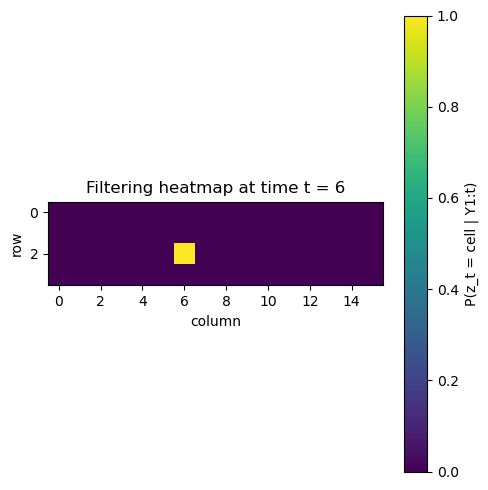

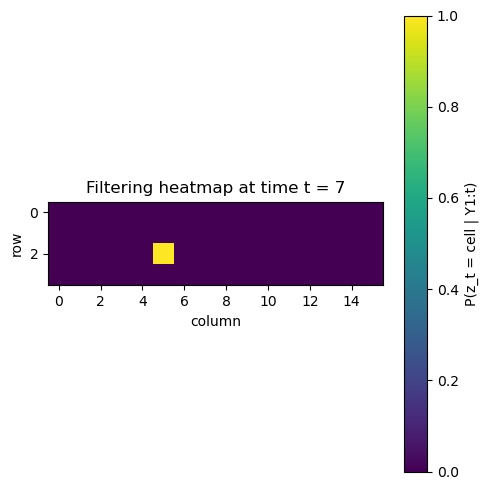

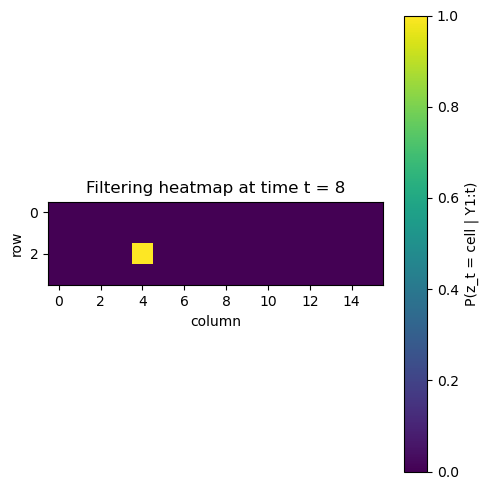

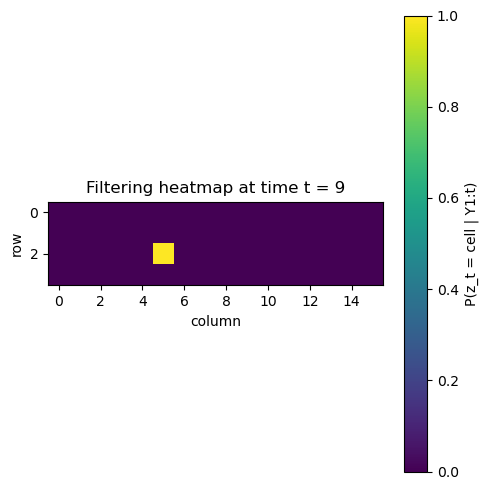

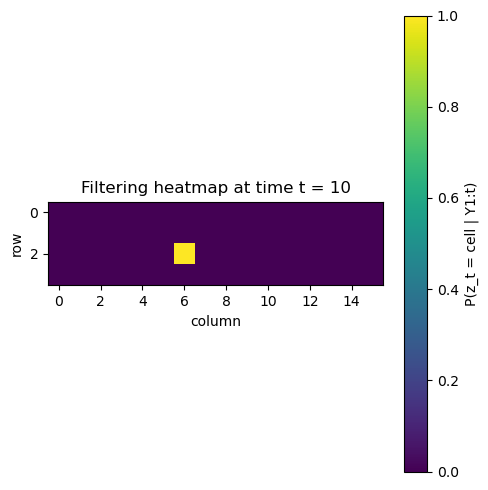

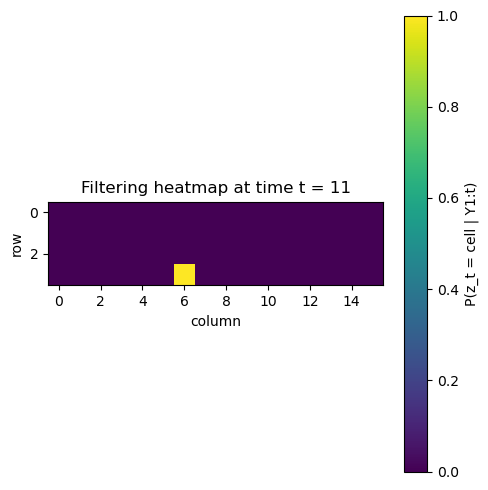

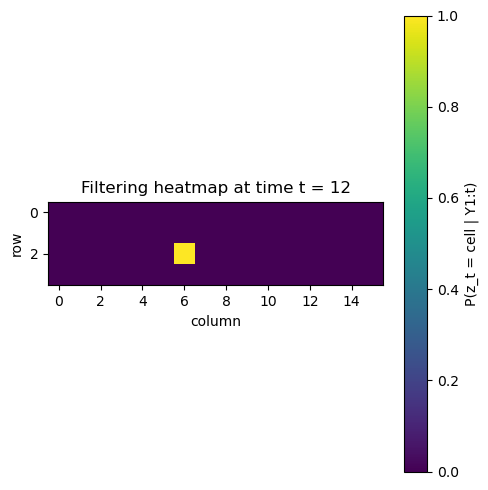

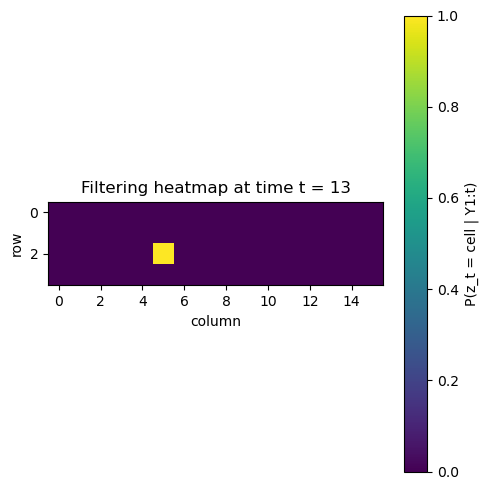

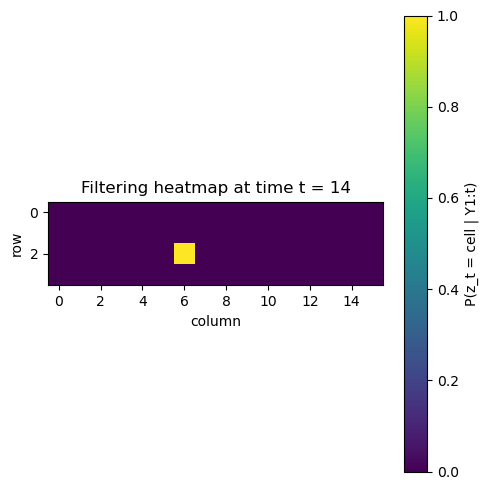

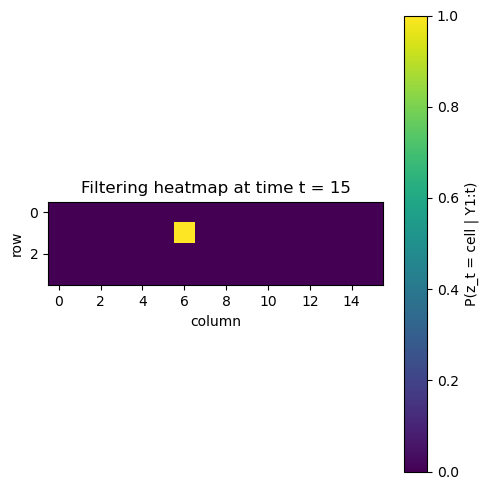

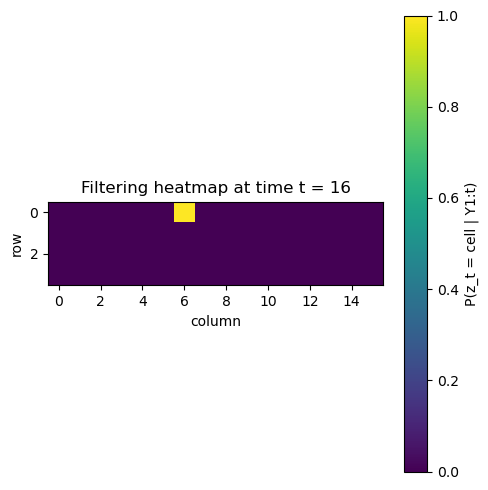

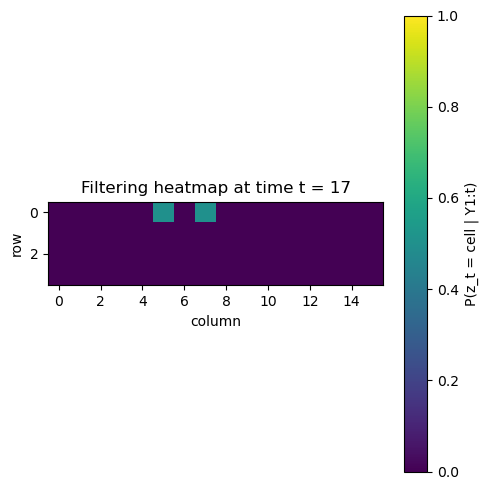

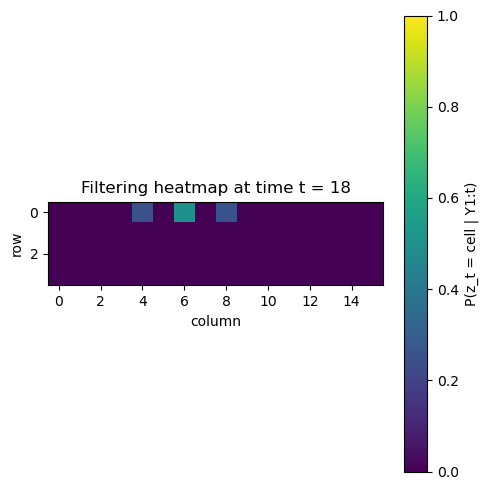

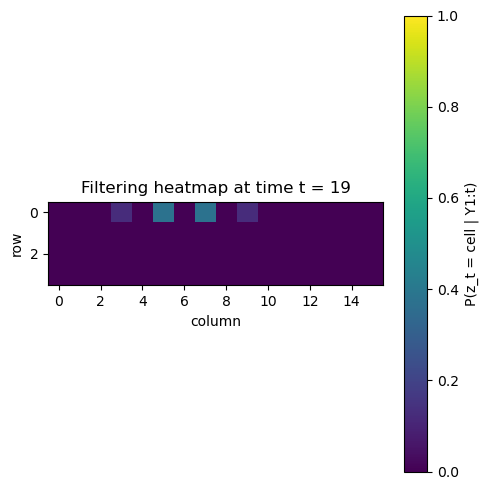

In [169]:
for t in range(T):
    plot_heatmap(alpha_all[t],t)

### 2.3 Noisy observations

Repeat steps 2.1 and 2.2 in the presence of sensor error noise. In particular, consider that:
  * With probability $1-\epsilon$, the sensor provides the correct reading
  * With probability $\epsilon$, the sensor returns a wrong reading. 
  * The $\epsilon$ probability is equally split among all wrong readings.
  * Set $\epsilon=0.2$. Optionally, test also other values.

In [170]:
B_noisy = B.copy()
noise_level = 0.2
for i in range(B_noisy.shape[0]):
    for j in range(B_noisy.shape[1]):
        if B_noisy[i, j] > 0:
            B_noisy[i, j] = B_noisy[i, j] - noise_level
        else:
            B_noisy[i, j] = (noise_level / (B_noisy.shape[1] - 1))
#print(B_noisy)
#print the sum of each row to verify they sum to 1
#for row in B_noisy:
#    print(f"Sum of row: {np.sum(row)}")

In [171]:
Z_noisy, Y_noisy = generate_sequence(T, A, B_noisy, pi, vocabulary)
print(Z_noisy)
print(Y_noisy)

[56 57 56 40 41 40 24 40 56 57 41 42 43 42 26 10 26 42 43 44]
['NE' 'EW' 'NS' 'SW' 'SEW' 'NSE' 'NS' 'NSE' 'NE' 'NEW' 'SEW' '' 'NSW' 'N'
 'NS' 'SW' 'NS' 'NSEW' 'NEW' 'NSEW']


In [172]:
print(f"The probability of our sequence is: {float(likelihood(A, B_noisy, pi, Y_noisy))}")

The probability of our sequence is: 5.2587961712129065e-21


In [173]:
Z_vit = viterbi(A, B_noisy, pi, Y_noisy)
print([states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit])
print([int(z) for z in Z_noisy])
Z_vit_list = [states_with_idx[z][1]+states_with_idx[z][0]*cols for z in Z_vit]

diffs = [a - b for a, b in zip(Z_noisy, Z_vit_list)]
res = [f'error at pos {i}' if int(z) != 0 else 'correct' for i,z in enumerate(diffs)]
print(res)

mismatches = sum(r != "correct" for r in res )
print(f"mismatch: {mismatches/len(res)}")

[56, 40, 24, 40, 41, 40, 24, 40, 56, 57, 41, 42, 26, 10, 26, 10, 26, 42, 26, 42]
[56, 57, 56, 40, 41, 40, 24, 40, 56, 57, 41, 42, 43, 42, 26, 10, 26, 42, 43, 44]
['correct', 'error at pos 1', 'error at pos 2', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'error at pos 12', 'error at pos 13', 'correct', 'correct', 'correct', 'correct', 'error at pos 18', 'error at pos 19']
mismatch: 0.3


t = 0, alpha = [0.00358423 0.00358423 0.00358423 0.00358423 0.00358423 0.00358423
 0.00358423 0.00358423 0.00358423 0.00358423 0.00358423 0.
 0.         0.         0.         0.00358423 0.00358423 0.00358423
 0.00358423 0.         0.00358423 0.         0.00358423 0.
 0.00358423 0.         0.00358423 0.         0.00358423 0.00358423
 0.         0.00358423 0.21505376 0.00358423 0.00358423 0.
 0.21505376 0.00358423 0.00358423 0.         0.00358423 0.00358423
 0.00358423 0.00358423 0.00358423 0.00358423 0.00358423 0.00358423
 0.         0.         0.         0.         0.         0.
 0.00358423 0.         0.21505376 0.00358423 0.00358423 0.
 0.21505376 0.00358423 0.         0.00358423]
t = 1, alpha = [2.89886582e-04 4.71065696e-04 5.07301518e-04 1.73931949e-02
 6.52244809e-04 1.73931949e-02 6.52244809e-04 1.73931949e-02
 6.52244809e-04 2.17414936e-02 4.34829873e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.17414936e-04
 1.33710186e-02 5.79773164e-04 4.71065696e-04 0.00

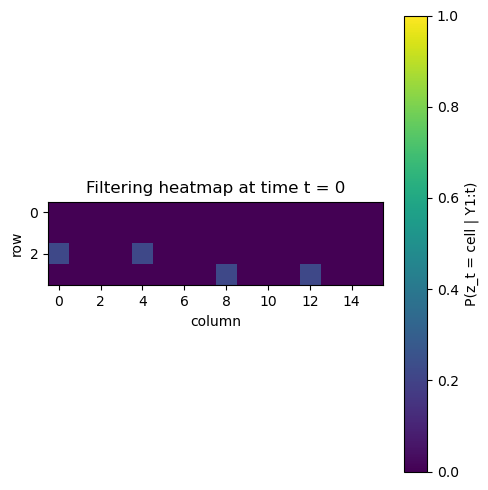

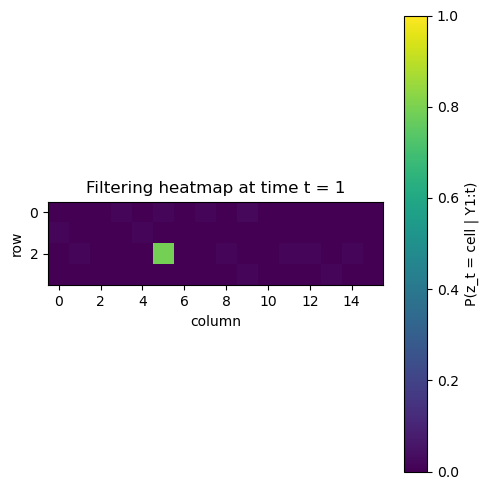

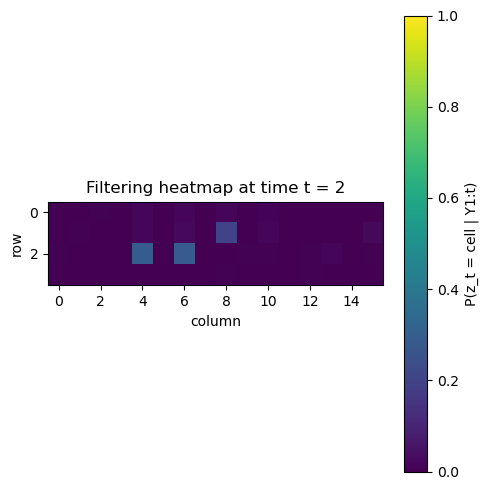

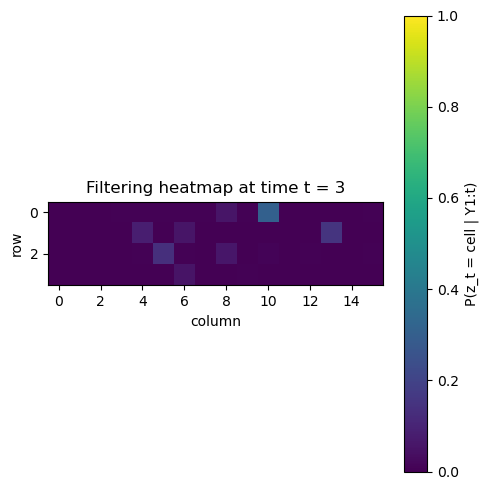

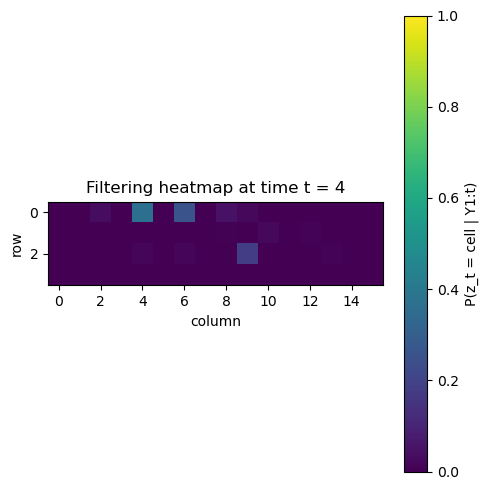

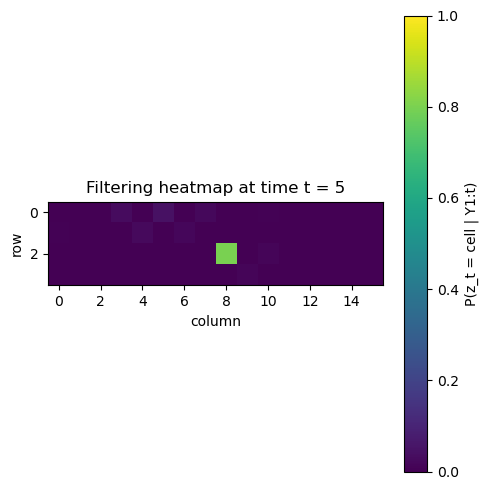

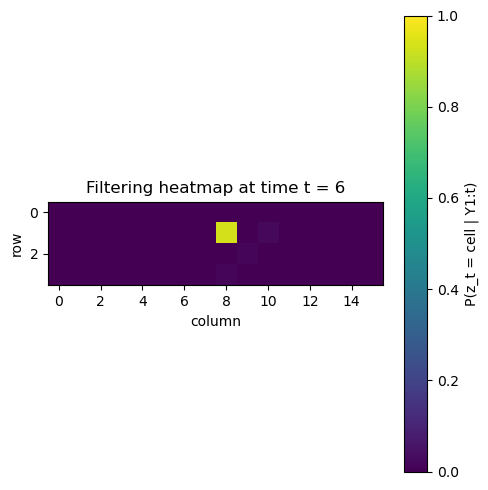

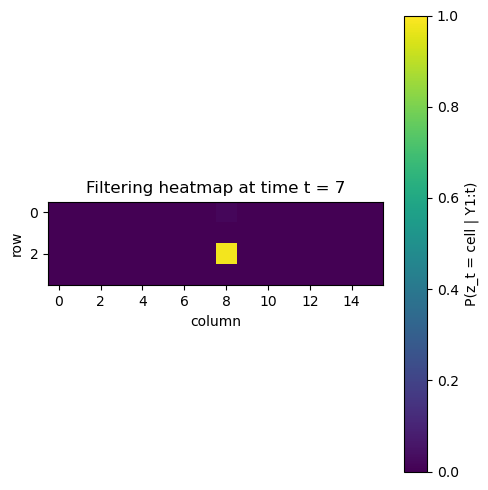

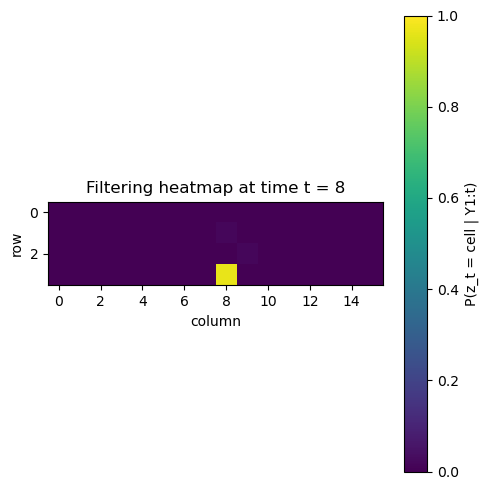

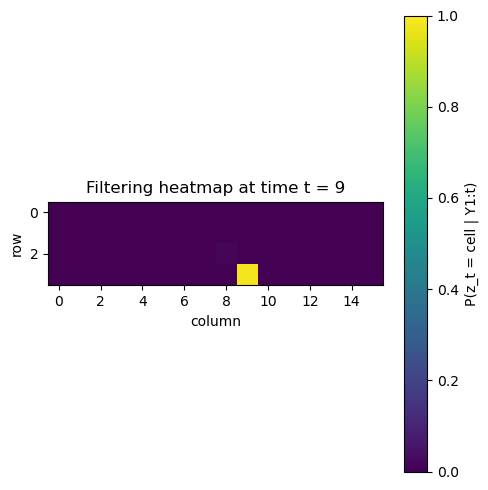

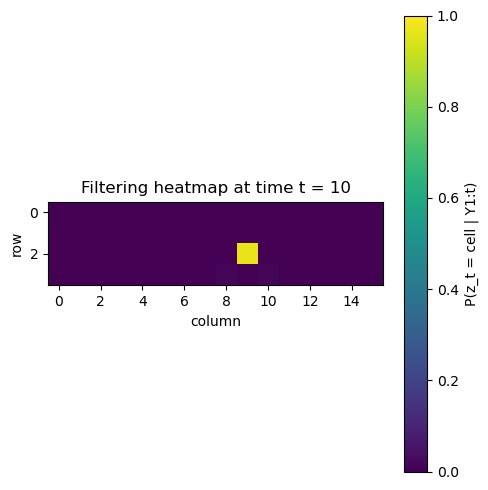

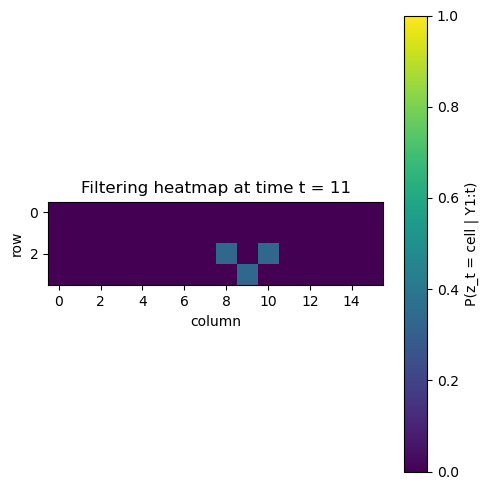

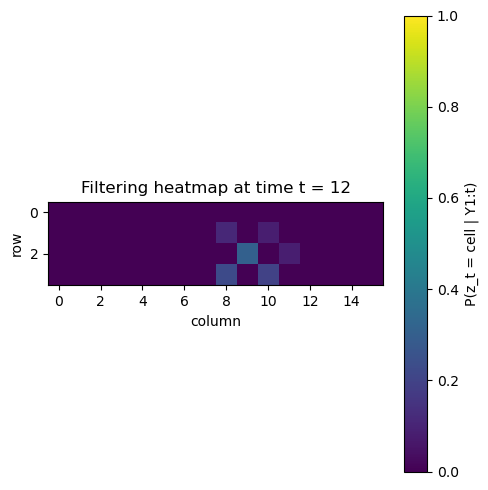

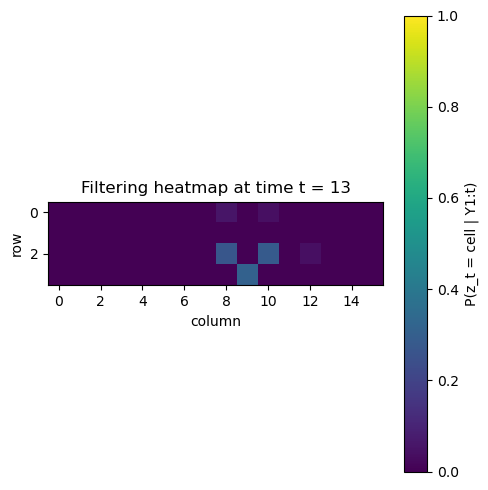

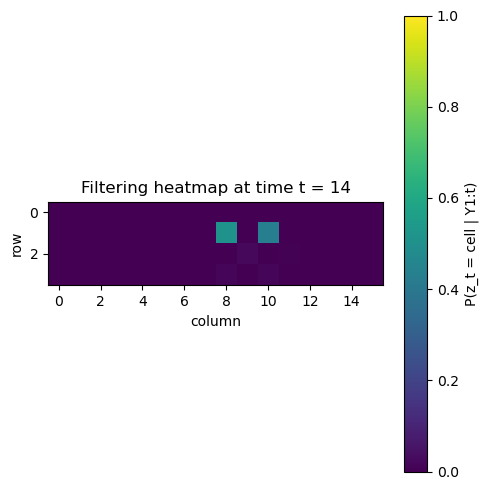

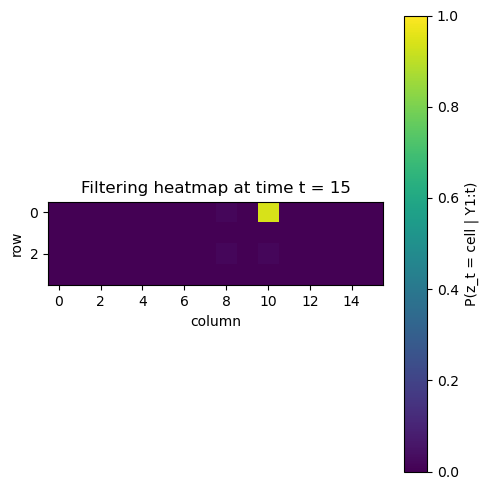

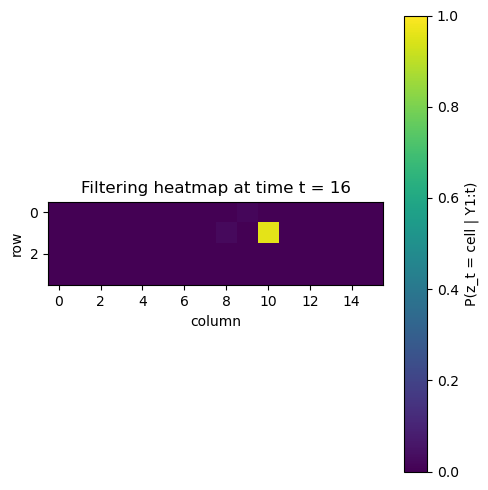

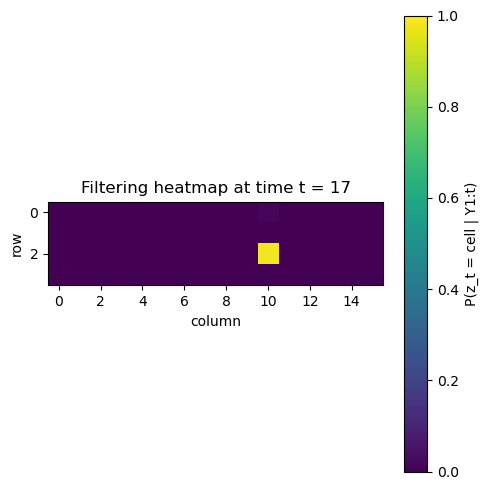

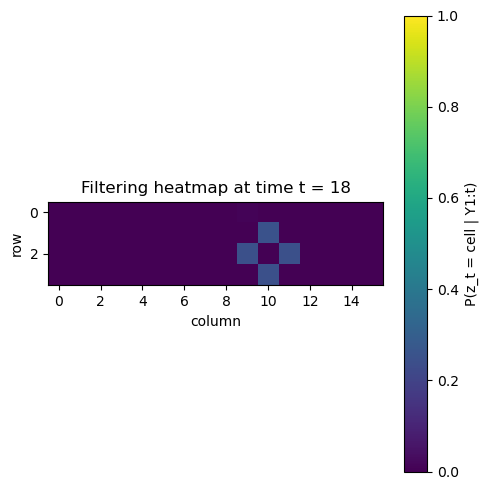

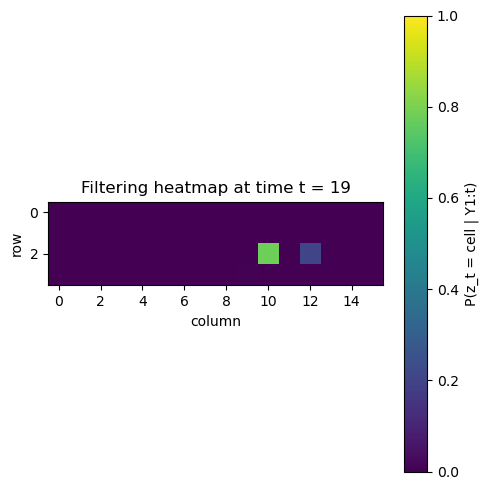

In [174]:
alpha_all = filtering(A, B_noisy, pi, Y_noisy)
for t in range(T):
    print(f"t = {t}, alpha = {alpha_all[t]}")
for t in range(T):
    plot_heatmap(alpha_all[t],t)

## 3 Analysis and discussion

Comment the techniques applied and the obtained results.